In [1]:
from pathlib import Path
import re
from collections import Counter, defaultdict
import math

import pandas as pd
import matplotlib.pyplot as plt

# Folders
DATA_DIR = Path("../../data") if Path(".").name != "applied-NLP-project" else Path("data")
RESULTS_DIR = Path("../../results") if Path(".").name != "applied-NLP-project" else Path("results")
OUT_DIR = RESULTS_DIR / "gender_language"
OUT_DIR.mkdir(parents=True, exist_ok=True)

BOOKS = {
    "War_and_Peace": DATA_DIR / "War_and_Peace.txt",
    "Anna_Karenina": DATA_DIR / "Anna_Karenina.txt",
}

# Sanity: make sure texts exist and are not tiny HTML error pages
for name, p in BOOKS.items():
    if not p.exists() or p.stat().st_size < 100000:
        raise FileNotFoundError(f"{name} missing/invalid: {p}")


In [2]:
def load_text(path: Path) -> str:
    return path.read_text(encoding="utf-8", errors="ignore")

def normalize(text: str) -> str:
    text = text.lower()
    text = text.replace("—"," ").replace("–"," ").replace("’","'")
    text = re.sub(r"[^a-z']+", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def tokenize(text: str):
    return text.split()

# simple stopwords (same as before)
STOP = {
    "the","and","to","of","a","i","in","that","was","he","his","it","you","is","for","with",
    "as","on","her","at","be","not","but","had","she","they","him","by","from","this","have",
    "or","my","we","all","so","one","were","me","are","said","an","which","their","there",
    "what","when","then","out","up","would","if","your","has","into","about","could","over",
    "them","no","more","who","do","did","than","been","any","only","very","some","because",
    "its","those","our","down","again","after"
}


In [3]:
male_terms = {
    "he","him","his","man","men","boy","boys","father","son","sons","brother","husband",
    "mr","sir","gentleman","gentlemen","prince","count","duke","baron","baronet","tsar","czar"
}
female_terms = {
    "she","her","hers","woman","women","girl","girls","mother","daughter","daughters","sister",
    "wife","mrs","miss","madam","lady","ladies","princess","countess","duchess","baroness","tsarina","czarina"
}

def per_10k(c, n): 
    return (c / n) * 10_000 if n else 0.0


In [4]:
tokens = {}
totals = {}
counts_gender = {}

for name, path in BOOKS.items():
    norm = normalize(load_text(path))
    toks = tokenize(norm)
    tokens[name] = toks
    totals[name] = len(toks)

    c_male = sum(1 for t in toks if t in male_terms)
    c_fem  = sum(1 for t in toks if t in female_terms)
    counts_gender[name] = {
        "male_count": c_male, "female_count": c_fem,
        "male_per10k": per_10k(c_male, totals[name]),
        "female_per10k": per_10k(c_fem, totals[name])
    }

pd.DataFrame.from_dict(counts_gender, orient="index").reset_index(names="book")


,book,male_count,female_count,male_per10k,female_per10k
0,War_and_Peace,28208,10890,486.253445,187.723342
1,Anna_Karenina,17947,11282,509.831884,320.494975


In [5]:
import numpy as np

rows = []
for book, d in counts_gender.items():
    m, f = d["male_count"], d["female_count"]
    # add small smoothing to avoid divide-by-zero
    log_ratio = np.log((m + 0.5) / (f + 0.5))
    # normalized index in [-1, 1]
    norm_idx = (m - f) / (m + f) if (m + f) > 0 else 0.0
    rows.append({
        "book": book,
        "male_count": m, "female_count": f,
        "male_per10k": d["male_per10k"], "female_per10k": d["female_per10k"],
        "bias_log_ratio_m_over_f": log_ratio,
        "bias_norm_index": norm_idx
    })

bias_df = pd.DataFrame(rows)
bias_df


,book,male_count,female_count,male_per10k,female_per10k,bias_log_ratio_m_over_f,bias_norm_index
0,War_and_Peace,28208,10890,486.253445,187.723342,0.951733,0.442938
1,Anna_Karenina,17947,11282,509.831884,320.494975,0.464198,0.228027


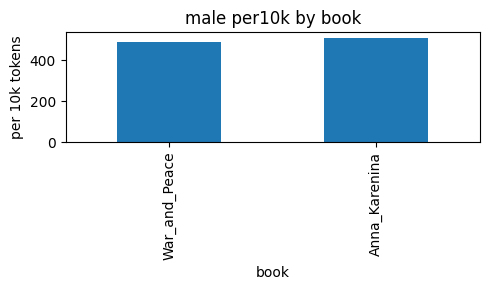

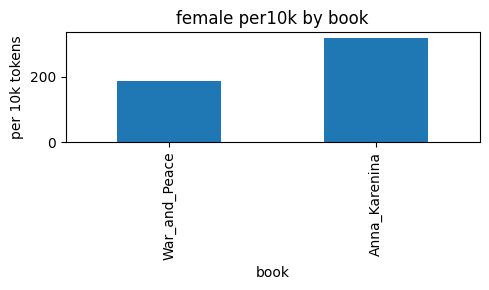

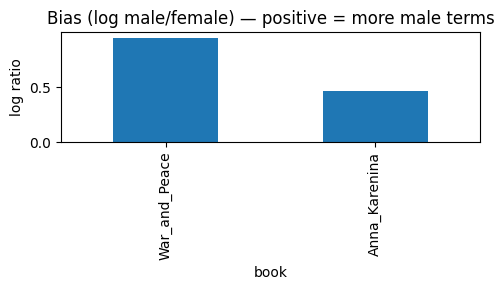

In [6]:
for col in ["male_per10k","female_per10k"]:
    plt.figure(figsize=(5,3))
    (bias_df.set_index("book")[col]).plot(kind="bar")
    plt.title(f"{col.replace('_',' ')} by book")
    plt.ylabel("per 10k tokens")
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(5,3))
(bias_df.set_index("book")["bias_log_ratio_m_over_f"]).plot(kind="bar")
plt.title("Bias (log male/female) — positive = more male terms")
plt.ylabel("log ratio")
plt.tight_layout()
plt.show()


In [7]:
WINDOW = 3  # words on each side

def collocates(toks, targets, window=3):
    hits = []
    for i, w in enumerate(toks):
        if w in targets:
            lo = max(0, i - window)
            hi = min(len(toks), i + window + 1)
            ctx = [t for j, t in enumerate(toks[lo:hi]) if j + lo != i and t not in STOP]
            hits.extend(ctx)
    return Counter(hits)

collos = {}
for book in BOOKS.keys():
    male_collos = collocates(tokens[book], male_terms, WINDOW)
    fem_collos  = collocates(tokens[book], female_terms, WINDOW)
    collos[book] = {
        "male": male_collos.most_common(30),
        "female": fem_collos.most_common(30)
    }

# Show top 15 collocates per side for each book
for book in BOOKS.keys():
    print(f"\n=== {book} — male collocates ===")
    print(pd.DataFrame(collos[book]["male"][:15], columns=["word","count"]))
    print(f"\n=== {book} — female collocates ===")
    print(pd.DataFrame(collos[book]["female"][:15], columns=["word","count"]))



=== War_and_Peace — male collocates ===
       word  count
0    andrew   1238
1   himself    558
2    pierre    552
3      eyes    545
4       old    504
5      face    502
6       now    463
7   thought    456
8      head    438
9    looked    420
10     went    397
11   prince    392
12     felt    377
13   before    371
14    asked    367

=== War_and_Peace — female collocates ===
        word  count
0       mary    649
1       face    286
2        sha    264
3       eyes    263
4        nat    233
5     little    210
6    herself    208
7    thought    197
8       felt    192
9      asked    189
10    father    178
11      went    178
12  princess    178
13      hand    174
14       now    174

=== Anna_Karenina — male collocates ===
       word  count
0     levin    441
1      felt    407
2      went    379
3   himself    372
4      eyes    341
5      wife    323
6   thought    316
7       now    310
8      knew    291
9       saw    287
10  brother    278
11     face    277
12  

In [8]:
# Per-book gender counts
pd.DataFrame.from_dict(counts_gender, orient="index").reset_index(names="book") \
  .to_csv(OUT_DIR / "gender_counts_per_book.csv", index=False)

# Bias summary
bias_df.to_csv(OUT_DIR / "gender_bias_summary.csv", index=False)

# Collocates — save each as CSV
for book in BOOKS.keys():
    pd.DataFrame(collos[book]["male"], columns=["word","count"]).to_csv(OUT_DIR / f"{book}_collocates_male.csv", index=False)
    pd.DataFrame(collos[book]["female"], columns=["word","count"]).to_csv(OUT_DIR / f"{book}_collocates_female.csv", index=False)

print("Saved files in:", OUT_DIR.as_posix())


Saved files in: ../../results/gender_language
